## Feature Selection

### <a href=#s2>Baseline</a>
### <a href=#s3>Correlations, basic OLS</a>
### <a href=#s4> Lasso Regularization</a>

In [1]:
import pandas as pd
import re
import numpy as np
import datetime as dt

import pipeline as p
import fitting as f
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# %reload_ext autoreload

In [2]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, make_scorer
scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error, greater_is_better=False)}

In [3]:
X_train = p.open_pkl('Data/X_train.pkl')
y_train  = p.open_pkl('Data/y_train.pkl')

train_df = X_train.join(y_train)
target = 'point_diff'

In [9]:
drop_df = train_df.dropna()

In [10]:
len(train_df), len(dum_df)

(2394, 2233)

### 2. Baseline <a name=s2 />
We know that FivethrityEight's Elo model includes only game Location, and Elo for Team & Opponent entering the week. We'll use this as our baseline

In [12]:
simple_cols = ['elo1_pre','elo2_pre','Location']

In [13]:
fit = f.simple_OLS(train_df, simple_cols, target)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     127.2
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.94e-76
Time:                        13:50:31   Log-Likelihood:                -9673.8
No. Observations:                2394   AIC:                         1.936e+04
Df Residuals:                    2390   BIC:                         1.938e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5278      5.800     -1.298      0.194     -18.900       3.845
elo1_pre       0.0435      0.003     15.465      0.000       0.038       0.049
elo2_pre      -0.0368      0.003    -12.883      0.000      -0.042      -0.031
Location       5.5119      4.376      1.259      0.208      -3.070      14.094
==============================================================================
Omnibus:                        9.648   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.076
Skew:                           0.044   Prob(JB):                      0.00239
Kurtosis:                       3.337   Cond. No.                     4.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

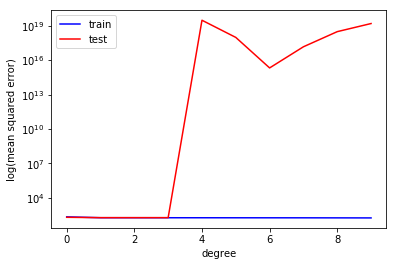

In [18]:
f.pick_degrees(train_df, simple_cols, target, max_deg=10)

In [20]:
f.assess_model_poly(train_df, simple_cols, target, 3)

R2: [0.1391764181742392, 0.10939677076437315, 0.10165485693416199, 0.15691001145904548, 0.14836121236309063]
MSE: [182.8893068496541, 187.90142494291965, 206.31428204292428, 184.27441628087618, 192.19252967941335]


[0.1310998539389821, 190.71439195915752]

### 2. Simple OLS, P-values  <a name=s2 />

In [247]:
drop_cols = ['score1', 'score2', 'elo_delta', 'Date', 'OT', 'Season','Date', 'point_diff', # must exclude these
             'Time'] # can re-include these at some point
all_cols = [x for x in train_df.columns if x not in drop_cols]

# remove Boolean categories for now
bool_cols = ['neutral', 'playoff', 'Location']
num_cols = [x for x in all_cols if (train_df.dtypes[x] != 'O' and x not in bool_cols)]
# num_cols = [x for x in num_cols if x not in bool_cols]

In [169]:
fit2a = f.simple_OLS(train_df, num_cols, target)
fit2a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.586
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           3.04e-57
Time:                        20:42:30   Log-Likelihood:                -8983.6
No. Observations:                2233   AIC:                         1.807e+04
Df Residuals:                    2180   BIC:                         1.838e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.4812     11.680     -0.298      0.766     -26.387      19.425
elo1_pre             0.0339      0.019      1.816      0.069      -0.003       0.070
elo2_pre            -0.0390      0.019     -2.076      0.038      -0.076      -0.002
elo_prob1           -3.3726      8.892     -0.379      0.704     -20.809      14.064
elo_prob2           -0.1085      9.471     -0.011      0.991     -18.682      18.465
Week                 0.0959      0.180      0.532      0.595      -0.257       0.449
Losses1             -0.0202      0.275     -0.074      0.941      -0.559       0.519
FirstD_SA1          -0.1700      0.348     -0.489      0.625      -0.852       0.512
PassY_SA1            0.0054      0.014      0.377      0.706      -0.023       0.033
PtsOpp_SA1          -0.3160      0.090     -3.528      0.000      -0.492      -0.140
PtsTm_SA1            0.1131      0.146      0.777      0.438      -0.173       0.399
RushY_SA1            0.0112      0.015      0.749      0.454      -0.018       0.041
TO_SA1               1.2124      1.103      1.099      0.272      -0.951       3.376
DefTO_SA1           -0.2647      0.610     -0.434      0.664      -1.461       0.932
TotY_SA1             0.0166      0.012      1.438      0.151      -0.006       0.039
RushAtt_SA1          0.1428      0.258      0.554      0.580      -0.362       0.648
RushTDs_SA1         -0.9123      1.138     -0.802      0.423      -3.144       1.320
PassCmp_SA1         -0.1534      0.635     -0.242      0.809      -1.398       1.092
PassAtt_SA1          0.3472      0.289      1.200      0.230      -0.220       0.915
PassTDs_SA1         -0.3301      1.716     -0.192      0.847      -3.695       3.035
INT_SA1             -0.7855      2.057     -0.382      0.703      -4.819       3.248
SacksO_SA1           0.3885      0.469      0.828      0.408      -0.531       1.308
Fumbles_SA1         -1.1795      0.729     -1.618      0.106      -2.609       0.250
Penalies_SA1         0.8395      0.452      1.859      0.063      -0.046       1.725
PenY_SA1            -0.0583      0.048     -1.221      0.222      -0.152       0.035
ThirdDConv_SA1       0.2900      0.549      0.528      0.598      -0.787       1.367
ThirdDAtt_SA1       -0.8420      0.733     -1.149      0.251      -2.279       0.595
FourthDAtt_SA1       0.3962      0.721      0.549      0.583      -1.018       1.811
PassCompPct_SA1      0.0700      0.273      0.257      0.797      -0.464       0.605
PassRating_SA1       0.0157      0.120      0.132      0.895      -0.219       0.250
TimePossMins_SA1    -0.2449      0.224     -1.095      0.274      -0.684       0.194
Losses2             -0.1045      0.281     -0.372      0.710      -0.655       0.446
FirstD_SA2           0.2048      0.326      0.629      0.530      -0.434       0.844
PassY_SA2           -0.

In [60]:
# this took too long
# f.pick_degrees(drop_df, num_cols, target, max_deg=6)

#### Get p-values. Select features whose p-values are less than 0.1. Run through Simple OLS

In [62]:
x_cols_02 = f.get_vars_low_pvals(fit2a, pval=0.3)

In [63]:
x_cols_02

['elo2_pre',
 'elo_prob2',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'SacksO_SA1',
 'Fumbles_SA1',
 'Penalies_SA1',
 'PenY_SA1',
 'ThirdDAtt_SA1',
 'TimePossMins_SA1',
 'PassCmp_SA2',
 'PassAtt_SA2',
 'SacksO_SA2',
 'ThirdDConv_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2',
 'PassCompPct_SA2']

In [64]:
fit2b = f.simple_OLS(train_df, x_cols_02, target)
fit2b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     23.44
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.47e-67
Time:                        12:43:48   Log-Likelihood:                -8780.0
No. Observations:                2180   AIC:                         1.760e+04
Df Residuals:                    2162   BIC:                         1.770e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -13.7590     18.169     -0.757      0.449     -49.390      21.872
elo2_pre            -0.0064      0.005     -1.205      0.228      -0.017       0.004
elo_prob2          -24.6556      3.433     -7.182      0.000     -31.388     -17.923
PtsOpp_SA1          -0.1858      0.072     -2.577      0.010      -0.327      -0.044
PtsTm_SA1            0.1905      0.074      2.574      0.010       0.045       0.336
SacksO_SA1           0.0196      0.366      0.054      0.957      -0.698       0.737
Fumbles_SA1         -0.5964      0.536     -1.112      0.266      -1.648       0.455
Penalies_SA1         0.7518      0.443      1.699      0.090      -0.116       1.620
PenY_SA1            -0.0565      0.047     -1.212      0.226      -0.148       0.035
ThirdDAtt_SA1       -0.3639      0.264     -1.381      0.167      -0.881       0.153
TimePossMins_SA1     0.0863      0.158      0.548      0.584      -0.223       0.396
PassCmp_SA2         -1.5183      0.760     -1.998      0.046      -3.009      -0.028
PassAtt_SA2          1.0083      0.483      2.086      0.037       0.060       1.956
SacksO_SA2          -0.5686      0.356     -1.599      0.110      -1.266       0.129
ThirdDConv_SA2      -1.0481      0.417     -2.515      0.012      -1.865      -0.231
ThirdDAtt_SA2        1.0087      0.376      2.684      0.007       0.272       1.746
FourthDAtt_SA2      -2.4717      0.682     -3.626      0.000      -3.809      -1.135
PassCompPct_SA2      0.4979      0.256      1.945      0.052      -0.004       1.000
==============================================================================
Omnibus:                        6.446   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.609
Skew:                           0.037   Prob(JB):                       0.0223
Kurtosis:                       3.280   Cond. No.                     9.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

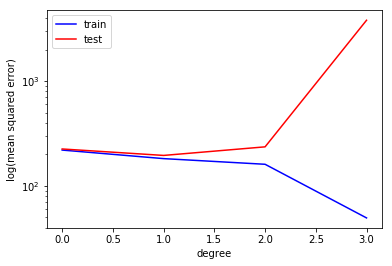

In [66]:
f.pick_degrees(drop_df, x_cols_02, target, max_deg=4)

In [77]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LinearRegression())

In [87]:
cross_validate(model, drop_df[x_cols_02], drop_df[target], cv=5)

{'fit_time': array([0.0261941 , 0.02080607, 0.02361417, 0.03113914, 0.01935482]),
 'score_time': array([0.0042479 , 0.00415802, 0.00434113, 0.00471377, 0.00299811]),
 'test_score': array([ 0.02540411,  0.05521943, -0.00917756,  0.12491351,  0.02072081]),
 'train_score': array([0.25714685, 0.24831231, 0.26684721, 0.23732483, 0.25235977])}

In [98]:
cross_validate(model, drop_df[x_cols_02], drop_df[target], cv=5, scoring=scoring)

{'fit_time': array([0.02418375, 0.02247405, 0.02764606, 0.02294016, 0.01614213]),
 'score_time': array([0.00540423, 0.00820184, 0.00975585, 0.00494504, 0.00566864]),
 'test_R2': array([ 0.02540411,  0.05521943, -0.00917756,  0.12491351,  0.02072081]),
 'train_R2': array([0.25714685, 0.24831231, 0.26684721, 0.23732483, 0.25235977]),
 'test_MSE': array([-205.81108224, -201.82975244, -235.63837476, -195.74643201,
        -217.24620784]),
 'train_MSE': array([-165.87238299, -167.46209341, -159.6939893 , -167.97473742,
        -164.93841978])}

### 3. Correlations. Simple OLS 
<a name=s3 />

In [99]:
dfc = train_df.corr()

In [100]:
dfc.head()

neutral   playoff  elo1_pre  elo2_pre  elo_prob1  elo_prob2  \
neutral    1.000000  0.163384  0.042063  0.035211  -0.048643   0.048643   
playoff    0.163384  1.000000  0.263349  0.232668   0.024405  -0.024405   
elo1_pre   0.042063  0.263349  1.000000  0.078979   0.679078  -0.679078   
elo2_pre   0.035211  0.232668  0.078979  1.000000  -0.668180   0.668180   
elo_prob1 -0.048643  0.024405  0.679078 -0.668180   1.000000  -1.000000   

             score1    score2  elo_delta  Location     ...      Fumbles_SA2  \
neutral    0.036028 -0.011074   0.046575  0.574923     ...        -0.009652   
playoff    0.043957  0.015035   0.020985 -0.012274     ...        -0.053064   
elo1_pre   0.253864 -0.143856   0.015556  0.022432     ...        -0.021965   
elo2_pre  -0.104216  0.223466   0.029954 -0.067223     ...        -0.255799   
elo_prob1  0.262944 -0.266919  -0.014642  0.032511     ...         0.170818   

           Penalies_SA2  PenY_SA2  ThirdDConv_SA2  ThirdDAtt_SA2  \
neutral        0.004452  0.007085        0.002381      -0.008463   
playoff       -0.054910 -0.039600        0.044052      -0.000052   
elo1_pre       0.000210 -0.002406        0.012896       0.000564   
elo2_pre      -0.099035 -0.058918        0.294676      -0.125691   
elo_prob1      0.074740  0.042551       -0.204143       0.090710   

           FourthDAtt_SA2  PassCompPct_SA2  PassRating_SA2  TimePossMins_SA2  \
neutral          0.022405         0.012401       -0.001855         -0.006728   
playoff         -0.021463         0.008864        0.062595          0.067479   
elo1_pre         0.023232        -0.004076        0.006638          0.021598   
elo2_pre        -0.252669         0.422980        0.528614          0.368514   
elo_prob1        0.198938        -0.306649       -0.378121         -0.247896   

           point_diff  
neutral      0.032840  
playoff      0.020771  
elo1_pre     0.275893  
elo2_pre    -0.224393  
elo_prob1    0.365467  

[5 rows x 64 columns]

In [ ]:
plt.plot(df)

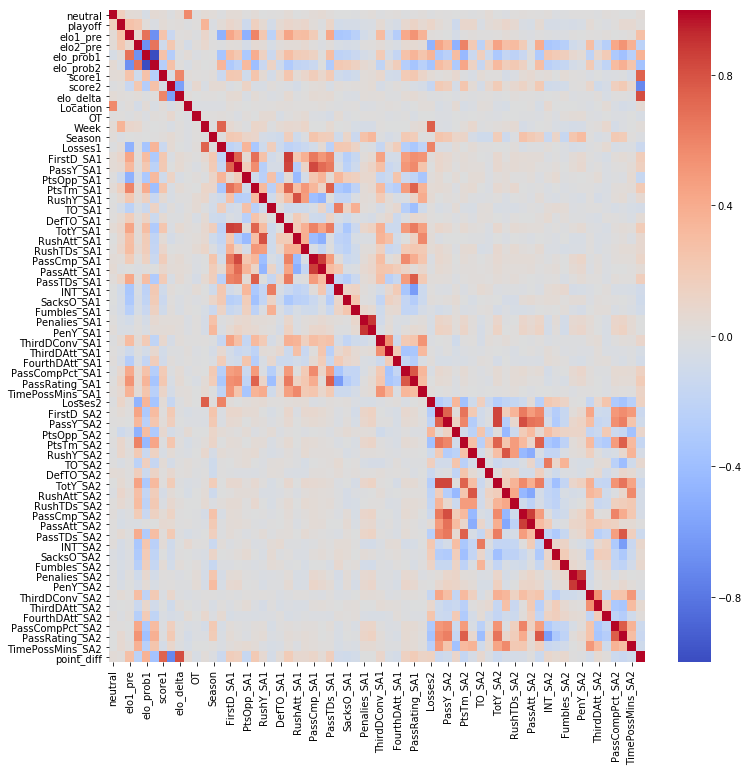

In [101]:
plt.figure(figsize=(12,12))
sns.heatmap(dfc, cmap='coolwarm')

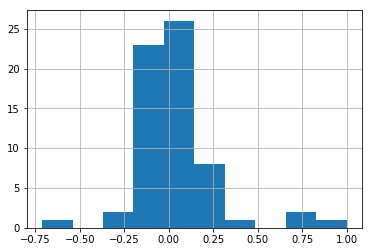

In [102]:
dfc[target].hist()

Most are ~0. But some aren't

In [103]:
corr_cols = list(dfc.loc[(abs(dfc[target]) > 0.1) & (dfc[target] < 1)][target].index)

In [104]:
corr_cols

['elo1_pre',
 'elo2_pre',
 'elo_prob1',
 'elo_prob2',
 'score1',
 'score2',
 'elo_delta',
 'Losses1',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassCmp_SA1',
 'PassTDs_SA1',
 'SacksO_SA1',
 'PassCompPct_SA1',
 'PassRating_SA1',
 'TimePossMins_SA1',
 'Losses2',
 'FirstD_SA2',
 'PtsTm_SA2',
 'TotY_SA2',
 'PassTDs_SA2',
 'PassCompPct_SA2',
 'PassRating_SA2',
 'TimePossMins_SA2']

In [105]:
drop_cols_02 = ['score1','score2','elo_delta']

In [106]:
corr_cols = [x for x in corr_cols if x not in drop_cols_02]

In [107]:
fit3 = f.simple_OLS(train_df, corr_cols, target)
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     17.00
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.76e-62
Time:                        13:08:55   Log-Likelihood:                -8782.7
No. Observations:                2180   AIC:                         1.761e+04
Df Residuals:                    2156   BIC:                         1.775e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.9417      7.223      1.238      0.216      -5.223      23.106
elo1_pre             0.0339      0.019      1.827      0.068      -0.002       0.070
elo2_pre            -0.0387      0.019     -2.076      0.038      -0.075      -0.002
elo_prob1            3.4401      7.656      0.449      0.653     -11.573      18.454
elo_prob2            5.5015      8.350      0.659      0.510     -10.874      21.877
Losses1              0.1061      0.211      0.503      0.615      -0.308       0.520
FirstD_SA1           0.0032      0.249      0.013      0.990      -0.486       0.492
PassY_SA1           -0.0018      0.021     -0.086      0.932      -0.043       0.040
PtsOpp_SA1          -0.2809      0.084     -3.332      0.001      -0.446      -0.116
PtsTm_SA1            0.0327      0.112      0.292      0.771      -0.187       0.252
TotY_SA1             0.0293      0.021      1.426      0.154      -0.011       0.070
PassCmp_SA1          0.1060      0.217      0.488      0.626      -0.320       0.532
PassTDs_SA1          0.8351      0.982      0.851      0.395      -1.090       2.760
SacksO_SA1           0.1663      0.372      0.447      0.655      -0.564       0.896
PassCompPct_SA1      0.0264      0.121      0.218      0.828      -0.211       0.264
PassRating_SA1      -0.0191      0.054     -0.356      0.722      -0.124       0.086
TimePossMins_SA1    -0.2358      0.178     -1.321      0.187      -0.586       0.114
Losses2             -0.0531      0.207     -0.256      0.798      -0.460       0.353
FirstD_SA2          -0.1729      0.213     -0.813      0.416      -0.590       0.244
PtsTm_SA2            0.0319      0.104      0.306      0.760      -0.173       0.236
TotY_SA2             0.0094      0.013      0.710      0.478      -0.017       0.035
PassTDs_SA2         -0.6302      0.852     -0.740      0.460      -2.301       1.041
PassCompPct_SA2     -0.0068      0.091     -0.076      0.940      -0.185       0.171
PassRating_SA2      -0.0086      0.045     -0.190      0.849      -0.097       0.080
TimePossMins_SA2    -0.0891      0.160     -0.558      0.577      -0.402       0.224
==============================================================================
Omnibus:                        9.375   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.660
Skew:                           0.052   Prob(JB):                      0.00294
Kurtosis:                       3.343   Cond. No.                     2.18e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.25e-29. This might indicate that there are
strong multicollinearity problems or that the desi

In [111]:
cross_validate(model, drop_df[corr_cols], drop_df[target], cv=5, scoring=scoring)

{'fit_time': array([0.05915689, 0.04078007, 0.03825521, 0.0394218 , 0.03854108]),
 'score_time': array([0.01808405, 0.00813174, 0.00827289, 0.00799298, 0.00793815]),
 'test_R2': array([-0.21947398, -0.22459094, -0.14736946,  0.04421348, -0.0941111 ]),
 'train_R2': array([0.31524401, 0.2767686 , 0.32623331, 0.29411646, 0.30372556]),
 'test_MSE': array([-257.52341278, -261.60454075, -267.90555655, -213.79806826,
        -242.72086182]),
 'train_MSE': array([-152.8998122 , -161.12255873, -146.75861892, -155.46671333,
        -153.60650896])}

### 4. Lasso Regularization to choose features <a name=s4 />

In [119]:
np.sum(pd.isna(drop_df[num_cols]))

neutral             0
playoff             0
elo1_pre            0
elo2_pre            0
elo_prob1           0
elo_prob2           0
Location            0
Week                0
Losses1             0
FirstD_SA1          0
PassY_SA1           0
PtsOpp_SA1          0
PtsTm_SA1           0
RushY_SA1           0
TO_SA1              0
DefTO_SA1           0
TotY_SA1            0
RushAtt_SA1         0
RushTDs_SA1         0
PassCmp_SA1         0
PassAtt_SA1         0
PassTDs_SA1         0
INT_SA1             0
SacksO_SA1          0
Fumbles_SA1         0
Penalies_SA1        0
PenY_SA1            0
ThirdDConv_SA1      0
ThirdDAtt_SA1       0
FourthDAtt_SA1      0
PassCompPct_SA1     0
PassRating_SA1      0
TimePossMins_SA1    0
Losses2             0
FirstD_SA2          0
PassY_SA2           0
PtsOpp_SA2          0
PtsTm_SA2           0
RushY_SA2           0
TO_SA2              0
DefTO_SA2           0
TotY_SA2            0
RushAtt_SA2         0
RushTDs_SA2         0
PassCmp_SA2         0
PassAtt_SA

In [70]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), LassoCV(cv=5))
results01 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [90]:
coefs01 = [results01['estimator'][i].get_params()['lassocv'].coef_ for i in range(5)]

coefs01_mean = np.mean(coefs01, axis=0)

idxs01 = np.argwhere(abs(coefs01_mean) > 1e-02)
idxs01 = [x[0] for x in idxs01]
lcv_cols_01 = [num_cols[x] for x in idxs]

alphas01 = [results01['estimator'][i].get_params()['lassocv'].alpha_ for i in range(5)]
alpha01_mean = np.mean(alphas01)

In [91]:
alphas01

[0.4218826952824352,
 0.371158624858281,
 0.4603829196174208,
 0.35305308827507453,
 0.3297324176404206]

In [92]:
alpha01_mean

0.3872419491347264

In [93]:
len(lcv_cols_01)

20

In [94]:
lcv_cols_01

['neutral',
 'elo2_pre',
 'elo_prob1',
 'Location',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassTDs_SA1',
 'Fumbles_SA1',
 'PassRating_SA1',
 'FirstD_SA2',
 'PtsTm_SA2',
 'TO_SA2',
 'PassAtt_SA2',
 'Fumbles_SA2',
 'PenY_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2']

In [63]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
# model = make_pipeline(StandardScaler(), LassoCV(cv=5))
results = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [88]:
coefs = [results['estimator'][i].get_params()['lassocv'].coef_ for i in range(5)]
coefs_mean = np.mean(coefs01, axis=0)

idxs02 = np.argwhere(abs(coefs01_mean) > 1e-02)
idxs02 = [x[0] for x in idxs02]

feat_names_02 = results['estimator'][1].get_params()['polynomialfeatures'].get_feature_names()
lcv_cols_02 = [feat_names_02[x] for x in idxs]

alphas02 = [results['estimator'][i].get_params()['lassocv'].alpha_ for i in range(5)]
alpha02_mean = np.mean(alphas02)

In [83]:
lcv_cols_02

['1',
 'x2',
 'x3',
 'x5',
 'x8',
 'x9',
 'x10',
 'x11',
 'x15',
 'x20',
 'x23',
 'x30',
 'x33',
 'x36',
 'x38',
 'x44',
 'x48',
 'x50',
 'x52',
 'x53']

No interactions or higher-order terms have "non-zero" coefficients

In [95]:
idxs01

[0, 3, 4, 6, 9, 10, 11, 12, 16, 21, 24, 31, 34, 37, 39, 45, 49, 51, 53, 54]

In [96]:
idxs02

[0, 3, 4, 6, 9, 10, 11, 12, 16, 21, 24, 31, 34, 37, 39, 45, 49, 51, 53, 54]

In [97]:
idxs01 == idxs02

True

All that to prove that we don't need a polynomial degree > 1

In [207]:
ols_lassocols = [np.mean(results01['test_R2']), -np.mean(results01['test_MSE'])]

In [109]:
print(f"Test R2: {np.mean(results01['test_R2']):.4f}")
print(f"Train R2: {np.mean(results01['train_R2']):.4f}")

Test R2: 0.1423
Train R2: 0.1554


In [110]:
print(f"Test MSE: {-np.mean(results01['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results01['train_MSE']):.1f}")

Test MSE: 188.7
Train MSE: 186.0


At least we aren't over-fitting. Fit is poor though

In [111]:
np.sqrt(-np.mean(results01['test_MSE']))

13.73651936520774

Avearge error is 14 points!

In [112]:
fit4 = f.simple_OLS(train_df, lcv_cols_01, target)
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             point_diff   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     21.30
Date:                Sun, 06 Jan 2019   Prob (F-statistic):           1.43e-70
Time:                        18:30:53   Log-Likelihood:                -8995.0
No. Observations:                2233   AIC:                         1.803e+04
Df Residuals:                    2212   BIC:                         1.815e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -6.9048     10.130     -0.682      0.496     -26.770      12.960
neutral            4.8594      3.102      1.567      0.117      -1.223      10.942
elo2_pre          -0.0068      0.005     -1.242      0.214      -0.018       0.004
elo_prob1         23.4406      3.405      6.883      0.000      16.763      30.119
Location           2.7878      5.336      0.522      0.601      -7.675      13.251
FirstD_SA1         0.0263      0.207      0.127      0.899      -0.380       0.432
PassY_SA1          0.0114      0.013      0.911      0.363      -0.013       0.036
PtsOpp_SA1        -0.2279      0.073     -3.107      0.002      -0.372      -0.084
PtsTm_SA1         -0.0009      0.098     -0.010      0.992      -0.193       0.191
TotY_SA1           0.0168      0.017      0.978      0.328      -0.017       0.050
PassTDs_SA1        0.7354      0.890      0.826      0.409      -1.010       2.481
Fumbles_SA1       -0.5236      0.518     -1.010      0.313      -1.540       0.493
PassRating_SA1     0.0033      0.027      0.125      0.901      -0.049       0.055
FirstD_SA2        -0.2207      0.161     -1.369      0.171      -0.537       0.095
PtsTm_SA2          0.0006      0.082      0.007      0.994      -0.159       0.161
TO_SA2             0.1118      0.571      0.196      0.845      -1.007       1.231
PassAtt_SA2        0.0926      0.074      1.258      0.209      -0.052       0.237
Fumbles_SA2        0.6177      0.597      1.035      0.301      -0.552       1.788
PenY_SA2          -0.0309      0.021     -1.461      0.144      -0.072       0.011
ThirdDAtt_SA2      0.4002      0.209      1.911      0.056      -0.011       0.811
FourthDAtt_SA2    -1.9132      0.659     -2.903      0.004      -3.206      -0.621
==============================================================================
Omnibus:                        7.010   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                8.373
Skew:                           0.038   Prob(JB):                       0.0152
Kurtosis:                       3.290   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
f.pick_degrees(train_df, lcv_cols_01, target, max_deg=4)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 5. Elastic Net

In [255]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5))
results03 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [256]:
coefs03 = [results03['estimator'][i].get_params()['elasticnetcv'].coef_ for i in range(5)]

coefs03_mean = np.mean(coefs03, axis=0)

idxs03 = np.argwhere(abs(coefs03_mean) > 1e-02)
idxs03 = [x[0] for x in idxs03]
elas_cols = [num_cols[x] for x in idxs03]

alphas03 = [results03['estimator'][i].get_params()['elasticnetcv'].alpha_ for i in range(5)]
alpha03_mean = np.mean(alphas01)

ratios03 = [results03['estimator'][i].get_params()['elasticnetcv'].l1_ratio_ for i in range(5)]
ratios03_mean = np.mean(alphas03)

In [257]:
elas_cols

['elo1_pre',
 'elo2_pre',
 'elo_prob1',
 'elo_prob2',
 'FirstD_SA1',
 'PassY_SA1',
 'PtsOpp_SA1',
 'PtsTm_SA1',
 'TotY_SA1',
 'PassCmp_SA1',
 'PassAtt_SA1',
 'PassTDs_SA1',
 'Fumbles_SA1',
 'Penalies_SA1',
 'ThirdDAtt_SA1',
 'PassRating_SA1',
 'Losses2',
 'FirstD_SA2',
 'PtsOpp_SA2',
 'PtsTm_SA2',
 'RushY_SA2',
 'TO_SA2',
 'TotY_SA2',
 'PassAtt_SA2',
 'PassTDs_SA2',
 'Fumbles_SA2',
 'PenY_SA2',
 'ThirdDConv_SA2',
 'ThirdDAtt_SA2',
 'FourthDAtt_SA2']

In [258]:
ols_elascols = [np.mean(results03['test_R2']), -np.mean(results03['test_MSE'])]

In [259]:
print(f"Test R2: {np.mean(results03['test_R2']):.4f}")
print(f"Train R2: {np.mean(results03['train_R2']):.4f}")

Test R2: 0.1431
Train R2: 0.1567


In [260]:
print(f"Test MSE: {-np.mean(results03['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results03['train_MSE']):.1f}")

Test MSE: 188.5
Train MSE: 185.7


### 6. Ridge CV

In [126]:
# model = make_pipeline(PolynomialFeatures(2), StandardScaler(), LassoCV(cv=5))
model = make_pipeline(StandardScaler(), RidgeCV(cv=5))
results04 = cross_validate(model, drop_df[num_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

In [127]:
print(f"Test R2: {np.mean(results04['test_R2']):.4f}")
print(f"Train R2: {np.mean(results04['train_R2']):.4f}")

Test R2: 0.1282
Train R2: 0.1758


In [128]:
print(f"Test MSE: {-np.mean(results04['test_MSE']):.1f}")
print(f"Train MSE: {-np.mean(results04['train_MSE']):.1f}")

Test MSE: 191.8
Train MSE: 181.5


Ridge performs slightly worse than Lasso or Elastic Net

## Cat Boost

In [129]:
from catboost import CatBoostRegressor

Determine indices of categorical_features

In [170]:
cat_cols = [x for x in all_cols if train_df.dtypes[x] == 'O']

In [171]:
# add Bool feartures
cat_cols = cat_cols + bool_cols

# get indicies
cb_df = drop_df[all_cols]
cat_idxs = [list(cb_df.columns).index(x) for x in cat_cols]

In [174]:
catX_train, catX_val, caty_train, caty_val = train_test_split(
    drop_df[all_cols], drop_df[target], test_size=0.25, random_state=12)

catX_train.reset_index(drop=True, inplace=True)
catX_val.reset_index(drop=True, inplace=True)

In [182]:
# model = make_pipeline()
model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='R2', iterations=500, 
                         learning_rate=0.05)

model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0115984	test: 0.0094434	best: 0.0094434 (0)	total: 95.8ms	remaining: 47.8s
1:	learn: 0.0214178	test: 0.0191037	best: 0.0191037 (1)	total: 137ms	remaining: 34.1s
2:	learn: 0.0317406	test: 0.0280536	best: 0.0280536 (2)	total: 170ms	remaining: 28.2s
3:	learn: 0.0407582	test: 0.0359265	best: 0.0359265 (3)	total: 198ms	remaining: 24.5s
4:	learn: 0.0505883	test: 0.0442173	best: 0.0442173 (4)	total: 226ms	remaining: 22.4s
5:	learn: 0.0587160	test: 0.0493975	best: 0.0493975 (5)	total: 279ms	remaining: 23s
6:	learn: 0.0664468	test: 0.0556957	best: 0.0556957 (6)	total: 309ms	remaining: 21.8s
7:	learn: 0.0730356	test: 0.0600127	best: 0.0600127 (7)	total: 338ms	remaining: 20.8s
8:	learn: 0.0796966	test: 0.0666820	best: 0.0666820 (8)	total: 367ms	remaining: 20s
9:	learn: 0.0865142	test: 0.0707987	best: 0.0707987 (9)	total: 393ms	remaining: 19.3s
10:	learn: 0.0932684	test: 0.0751231	best: 0.0751231 (10)	total: 454ms	remaining: 20.2s
11:	learn: 0.0996281	test: 0.0784540	best: 0.0784540 (1

101:	learn: 0.2658421	test: 0.1320426	best: 0.1328446 (92)	total: 3.17s	remaining: 12.3s
102:	learn: 0.2670505	test: 0.1329131	best: 0.1329131 (102)	total: 3.22s	remaining: 12.4s
103:	learn: 0.2688215	test: 0.1325883	best: 0.1329131 (102)	total: 3.24s	remaining: 12.3s
104:	learn: 0.2696202	test: 0.1327748	best: 0.1329131 (102)	total: 3.26s	remaining: 12.3s
105:	learn: 0.2703490	test: 0.1327939	best: 0.1329131 (102)	total: 3.29s	remaining: 12.2s
106:	learn: 0.2709179	test: 0.1322695	best: 0.1329131 (102)	total: 3.31s	remaining: 12.1s
107:	learn: 0.2709475	test: 0.1322428	best: 0.1329131 (102)	total: 3.32s	remaining: 12s
108:	learn: 0.2714211	test: 0.1322980	best: 0.1329131 (102)	total: 3.33s	remaining: 11.9s
109:	learn: 0.2725208	test: 0.1313135	best: 0.1329131 (102)	total: 3.36s	remaining: 11.9s
110:	learn: 0.2742429	test: 0.1313691	best: 0.1329131 (102)	total: 3.39s	remaining: 11.9s
111:	learn: 0.2753021	test: 0.1311482	best: 0.1329131 (102)	total: 3.42s	remaining: 11.9s
112:	learn: 0

194:	learn: 0.3497403	test: 0.1248446	best: 0.1329131 (102)	total: 5.76s	remaining: 9.01s
195:	learn: 0.3504087	test: 0.1245311	best: 0.1329131 (102)	total: 5.79s	remaining: 8.98s
196:	learn: 0.3509778	test: 0.1244758	best: 0.1329131 (102)	total: 5.83s	remaining: 8.97s
197:	learn: 0.3513956	test: 0.1242271	best: 0.1329131 (102)	total: 5.86s	remaining: 8.93s
198:	learn: 0.3532288	test: 0.1237887	best: 0.1329131 (102)	total: 5.88s	remaining: 8.89s
199:	learn: 0.3541824	test: 0.1237968	best: 0.1329131 (102)	total: 5.9s	remaining: 8.85s
200:	learn: 0.3559425	test: 0.1234825	best: 0.1329131 (102)	total: 5.92s	remaining: 8.8s
201:	learn: 0.3569439	test: 0.1237850	best: 0.1329131 (102)	total: 5.98s	remaining: 8.82s
202:	learn: 0.3585378	test: 0.1240580	best: 0.1329131 (102)	total: 6.01s	remaining: 8.79s
203:	learn: 0.3590577	test: 0.1241004	best: 0.1329131 (102)	total: 6.04s	remaining: 8.76s
204:	learn: 0.3596862	test: 0.1241450	best: 0.1329131 (102)	total: 6.06s	remaining: 8.72s
205:	learn: 

286:	learn: 0.4229714	test: 0.1273015	best: 0.1329131 (102)	total: 8.59s	remaining: 6.38s
287:	learn: 0.4236777	test: 0.1271846	best: 0.1329131 (102)	total: 8.62s	remaining: 6.35s
288:	learn: 0.4244071	test: 0.1263300	best: 0.1329131 (102)	total: 8.65s	remaining: 6.31s
289:	learn: 0.4250732	test: 0.1264395	best: 0.1329131 (102)	total: 8.69s	remaining: 6.29s
290:	learn: 0.4255346	test: 0.1265733	best: 0.1329131 (102)	total: 8.71s	remaining: 6.26s
291:	learn: 0.4257606	test: 0.1264506	best: 0.1329131 (102)	total: 8.73s	remaining: 6.22s
292:	learn: 0.4260309	test: 0.1265734	best: 0.1329131 (102)	total: 8.75s	remaining: 6.18s
293:	learn: 0.4267743	test: 0.1262540	best: 0.1329131 (102)	total: 8.77s	remaining: 6.15s
294:	learn: 0.4273268	test: 0.1259899	best: 0.1329131 (102)	total: 8.83s	remaining: 6.14s
295:	learn: 0.4276957	test: 0.1258310	best: 0.1329131 (102)	total: 8.86s	remaining: 6.1s
296:	learn: 0.4286575	test: 0.1259003	best: 0.1329131 (102)	total: 8.88s	remaining: 6.07s
297:	learn:

382:	learn: 0.4879150	test: 0.1238467	best: 0.1329131 (102)	total: 11.7s	remaining: 3.56s
383:	learn: 0.4883799	test: 0.1236965	best: 0.1329131 (102)	total: 11.7s	remaining: 3.53s
384:	learn: 0.4900022	test: 0.1237766	best: 0.1329131 (102)	total: 11.7s	remaining: 3.5s
385:	learn: 0.4904342	test: 0.1239635	best: 0.1329131 (102)	total: 11.8s	remaining: 3.47s
386:	learn: 0.4919198	test: 0.1243993	best: 0.1329131 (102)	total: 11.8s	remaining: 3.44s
387:	learn: 0.4923310	test: 0.1247304	best: 0.1329131 (102)	total: 11.8s	remaining: 3.41s
388:	learn: 0.4924646	test: 0.1246176	best: 0.1329131 (102)	total: 11.8s	remaining: 3.37s
389:	learn: 0.4929846	test: 0.1245272	best: 0.1329131 (102)	total: 11.9s	remaining: 3.35s
390:	learn: 0.4937972	test: 0.1244223	best: 0.1329131 (102)	total: 11.9s	remaining: 3.32s
391:	learn: 0.4944726	test: 0.1238108	best: 0.1329131 (102)	total: 11.9s	remaining: 3.28s
392:	learn: 0.4944933	test: 0.1237881	best: 0.1329131 (102)	total: 11.9s	remaining: 3.25s
393:	learn:

476:	learn: 0.5358821	test: 0.1183327	best: 0.1329131 (102)	total: 14.7s	remaining: 708ms
477:	learn: 0.5364279	test: 0.1185502	best: 0.1329131 (102)	total: 14.7s	remaining: 677ms
478:	learn: 0.5366607	test: 0.1184698	best: 0.1329131 (102)	total: 14.7s	remaining: 647ms
479:	learn: 0.5368520	test: 0.1184924	best: 0.1329131 (102)	total: 14.8s	remaining: 616ms
480:	learn: 0.5373318	test: 0.1182090	best: 0.1329131 (102)	total: 14.8s	remaining: 585ms
481:	learn: 0.5373941	test: 0.1181265	best: 0.1329131 (102)	total: 14.8s	remaining: 554ms
482:	learn: 0.5377668	test: 0.1183324	best: 0.1329131 (102)	total: 14.9s	remaining: 523ms
483:	learn: 0.5379394	test: 0.1183533	best: 0.1329131 (102)	total: 14.9s	remaining: 492ms
484:	learn: 0.5380316	test: 0.1185114	best: 0.1329131 (102)	total: 14.9s	remaining: 462ms
485:	learn: 0.5387078	test: 0.1185088	best: 0.1329131 (102)	total: 15s	remaining: 431ms
486:	learn: 0.5395083	test: 0.1188605	best: 0.1329131 (102)	total: 15s	remaining: 400ms
487:	learn: 0.

In [183]:
# model = make_pipeline()
model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='RMSE', iterations=500, 
                         learning_rate=0.05)

model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.1577426	test: 14.4830147	best: 14.4830147 (0)	total: 50.9ms	remaining: 25.4s
1:	learn: 15.0550323	test: 14.3959774	best: 14.3959774 (1)	total: 108ms	remaining: 26.9s
2:	learn: 14.9506752	test: 14.3152652	best: 14.3152652 (2)	total: 143ms	remaining: 23.7s
3:	learn: 14.8591796	test: 14.2450878	best: 14.2450878 (3)	total: 171ms	remaining: 21.2s
4:	learn: 14.7629011	test: 14.1733967	best: 14.1733967 (4)	total: 199ms	remaining: 19.7s
5:	learn: 14.6819046	test: 14.1260338	best: 14.1260338 (5)	total: 255ms	remaining: 21s
6:	learn: 14.6052785	test: 14.0719225	best: 14.0719225 (6)	total: 284ms	remaining: 20s
7:	learn: 14.5392635	test: 14.0329659	best: 14.0329659 (7)	total: 311ms	remaining: 19.1s
8:	learn: 14.4736177	test: 13.9775615	best: 13.9775615 (8)	total: 340ms	remaining: 18.6s
9:	learn: 14.4081301	test: 13.9423202	best: 13.9423202 (9)	total: 368ms	remaining: 18s
10:	learn: 14.3442787	test: 13.9061794	best: 13.9061794 (10)	total: 420ms	remaining: 18.7s
11:	learn: 14.2842356	te

93:	learn: 12.8859970	test: 13.5009500	best: 13.4931128 (61)	total: 3.89s	remaining: 16.8s
94:	learn: 12.8809287	test: 13.5055758	best: 13.4931128 (61)	total: 3.94s	remaining: 16.8s
95:	learn: 12.8693412	test: 13.5034543	best: 13.4931128 (61)	total: 3.97s	remaining: 16.7s
96:	learn: 12.8580800	test: 13.5030764	best: 13.4931128 (61)	total: 4.03s	remaining: 16.7s
97:	learn: 12.8533948	test: 13.5019732	best: 13.4931128 (61)	total: 4.05s	remaining: 16.6s
98:	learn: 12.8332357	test: 13.5107169	best: 13.4931128 (61)	total: 4.08s	remaining: 16.5s
99:	learn: 12.8259450	test: 13.5050182	best: 13.4931128 (61)	total: 4.11s	remaining: 16.4s
100:	learn: 12.8223804	test: 13.5037608	best: 13.4931128 (61)	total: 4.13s	remaining: 16.3s
101:	learn: 12.8143567	test: 13.5040474	best: 13.4931128 (61)	total: 4.16s	remaining: 16.2s
102:	learn: 12.8038064	test: 13.4969892	best: 13.4931128 (61)	total: 4.21s	remaining: 16.2s
103:	learn: 12.7883258	test: 13.4991999	best: 13.4931128 (61)	total: 4.23s	remaining: 1

186:	learn: 12.1384869	test: 13.5393929	best: 13.4931128 (61)	total: 6.56s	remaining: 11s
187:	learn: 12.1352352	test: 13.5375964	best: 13.4931128 (61)	total: 6.59s	remaining: 10.9s
188:	learn: 12.1298550	test: 13.5382518	best: 13.4931128 (61)	total: 6.61s	remaining: 10.9s
189:	learn: 12.1133819	test: 13.5368335	best: 13.4931128 (61)	total: 6.63s	remaining: 10.8s
190:	learn: 12.1068612	test: 13.5388933	best: 13.4931128 (61)	total: 6.66s	remaining: 10.8s
191:	learn: 12.0967988	test: 13.5444714	best: 13.4931128 (61)	total: 6.7s	remaining: 10.7s
192:	learn: 12.0790662	test: 13.5497573	best: 13.4931128 (61)	total: 6.72s	remaining: 10.7s
193:	learn: 12.0679345	test: 13.5508371	best: 13.4931128 (61)	total: 6.74s	remaining: 10.6s
194:	learn: 12.0599348	test: 13.5529259	best: 13.4931128 (61)	total: 6.77s	remaining: 10.6s
195:	learn: 12.0537346	test: 13.5553150	best: 13.4931128 (61)	total: 6.8s	remaining: 10.5s
196:	learn: 12.0484534	test: 13.5559096	best: 13.4931128 (61)	total: 6.84s	remaining

277:	learn: 11.4061479	test: 13.5269786	best: 13.4931128 (61)	total: 9.17s	remaining: 7.33s
278:	learn: 11.4023243	test: 13.5244978	best: 13.4931128 (61)	total: 9.2s	remaining: 7.29s
279:	learn: 11.4015927	test: 13.5249039	best: 13.4931128 (61)	total: 9.25s	remaining: 7.26s
280:	learn: 11.3981784	test: 13.5252667	best: 13.4931128 (61)	total: 9.27s	remaining: 7.22s
281:	learn: 11.3937465	test: 13.5239608	best: 13.4931128 (61)	total: 9.29s	remaining: 7.18s
282:	learn: 11.3879284	test: 13.5250296	best: 13.4931128 (61)	total: 9.31s	remaining: 7.14s
283:	learn: 11.3868890	test: 13.5273260	best: 13.4931128 (61)	total: 9.33s	remaining: 7.1s
284:	learn: 11.3696144	test: 13.5299615	best: 13.4931128 (61)	total: 9.39s	remaining: 7.08s
285:	learn: 11.3618377	test: 13.5311087	best: 13.4931128 (61)	total: 9.44s	remaining: 7.06s
286:	learn: 11.3605715	test: 13.5306681	best: 13.4931128 (61)	total: 9.47s	remaining: 7.03s
287:	learn: 11.3536170	test: 13.5315052	best: 13.4931128 (61)	total: 9.51s	remaini

369:	learn: 10.8153877	test: 13.5393191	best: 13.4931128 (61)	total: 12.6s	remaining: 4.43s
370:	learn: 10.8127834	test: 13.5423716	best: 13.4931128 (61)	total: 12.6s	remaining: 4.4s
371:	learn: 10.8007526	test: 13.5393854	best: 13.4931128 (61)	total: 12.7s	remaining: 4.36s
372:	learn: 10.7867513	test: 13.5441919	best: 13.4931128 (61)	total: 12.7s	remaining: 4.32s
373:	learn: 10.7722035	test: 13.5467252	best: 13.4931128 (61)	total: 12.7s	remaining: 4.28s
374:	learn: 10.7607825	test: 13.5505703	best: 13.4931128 (61)	total: 12.8s	remaining: 4.25s
375:	learn: 10.7491281	test: 13.5513620	best: 13.4931128 (61)	total: 12.8s	remaining: 4.21s
376:	learn: 10.7444138	test: 13.5516368	best: 13.4931128 (61)	total: 12.8s	remaining: 4.18s
377:	learn: 10.7396176	test: 13.5539741	best: 13.4931128 (61)	total: 12.8s	remaining: 4.14s
378:	learn: 10.7320508	test: 13.5563382	best: 13.4931128 (61)	total: 12.9s	remaining: 4.11s
379:	learn: 10.7311322	test: 13.5563659	best: 13.4931128 (61)	total: 12.9s	remain

460:	learn: 10.2674572	test: 13.5631494	best: 13.4931128 (61)	total: 16.2s	remaining: 1.37s
461:	learn: 10.2580951	test: 13.5645523	best: 13.4931128 (61)	total: 16.2s	remaining: 1.34s
462:	learn: 10.2514371	test: 13.5681893	best: 13.4931128 (61)	total: 16.3s	remaining: 1.3s
463:	learn: 10.2510309	test: 13.5688631	best: 13.4931128 (61)	total: 16.3s	remaining: 1.27s
464:	learn: 10.2476711	test: 13.5720572	best: 13.4931128 (61)	total: 16.4s	remaining: 1.23s
465:	learn: 10.2361867	test: 13.5715647	best: 13.4931128 (61)	total: 16.4s	remaining: 1.2s
466:	learn: 10.2293829	test: 13.5781374	best: 13.4931128 (61)	total: 16.4s	remaining: 1.16s
467:	learn: 10.2223624	test: 13.5821156	best: 13.4931128 (61)	total: 16.5s	remaining: 1.13s
468:	learn: 10.2214934	test: 13.5815467	best: 13.4931128 (61)	total: 16.5s	remaining: 1.09s
469:	learn: 10.2207622	test: 13.5818551	best: 13.4931128 (61)	total: 16.6s	remaining: 1.06s
470:	learn: 10.2110085	test: 13.5826649	best: 13.4931128 (61)	total: 16.6s	remaini

In [181]:
# model = make_pipeline()
model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='RMSE', iterations=500, 
                         learning_rate=0.01)

model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.2524843	test: 14.5523094	best: 14.5523094 (0)	total: 60.3ms	remaining: 30.1s
1:	learn: 15.2265428	test: 14.5313154	best: 14.5313154 (1)	total: 80ms	remaining: 19.9s
2:	learn: 15.2049041	test: 14.5152751	best: 14.5152751 (2)	total: 110ms	remaining: 18.2s
3:	learn: 15.1813579	test: 14.4950426	best: 14.4950426 (3)	total: 136ms	remaining: 16.8s
4:	learn: 15.1552787	test: 14.4759168	best: 14.4759168 (4)	total: 165ms	remaining: 16.3s
5:	learn: 15.1318091	test: 14.4570741	best: 14.4570741 (5)	total: 220ms	remaining: 18.1s
6:	learn: 15.1075619	test: 14.4372590	best: 14.4372590 (6)	total: 249ms	remaining: 17.6s
7:	learn: 15.0841739	test: 14.4211561	best: 14.4211561 (7)	total: 280ms	remaining: 17.2s
8:	learn: 15.0615556	test: 14.4016376	best: 14.4016376 (8)	total: 310ms	remaining: 16.9s
9:	learn: 15.0394311	test: 14.3837417	best: 14.3837417 (9)	total: 336ms	remaining: 16.5s
10:	learn: 15.0183527	test: 14.3664296	best: 14.3664296 (10)	total: 392ms	remaining: 17.4s
11:	learn: 14.99805

94:	learn: 13.9967519	test: 13.6835513	best: 13.6835513 (94)	total: 3.18s	remaining: 13.6s
95:	learn: 13.9893009	test: 13.6795080	best: 13.6795080 (95)	total: 3.21s	remaining: 13.5s
96:	learn: 13.9845478	test: 13.6761990	best: 13.6761990 (96)	total: 3.22s	remaining: 13.4s
97:	learn: 13.9784739	test: 13.6734834	best: 13.6734834 (97)	total: 3.25s	remaining: 13.3s
98:	learn: 13.9728331	test: 13.6705794	best: 13.6705794 (98)	total: 3.29s	remaining: 13.3s
99:	learn: 13.9635912	test: 13.6666883	best: 13.6666883 (99)	total: 3.32s	remaining: 13.3s
100:	learn: 13.9539359	test: 13.6636788	best: 13.6636788 (100)	total: 3.34s	remaining: 13.2s
101:	learn: 13.9448022	test: 13.6613848	best: 13.6613848 (101)	total: 3.36s	remaining: 13.1s
102:	learn: 13.9401589	test: 13.6583956	best: 13.6583956 (102)	total: 3.37s	remaining: 13s
103:	learn: 13.9341883	test: 13.6593022	best: 13.6583956 (102)	total: 3.4s	remaining: 12.9s
104:	learn: 13.9264491	test: 13.6572224	best: 13.6572224 (104)	total: 3.47s	remaining

186:	learn: 13.5759045	test: 13.5084709	best: 13.5082034 (185)	total: 5.54s	remaining: 9.27s
187:	learn: 13.5725073	test: 13.5079401	best: 13.5079401 (187)	total: 5.59s	remaining: 9.27s
188:	learn: 13.5686872	test: 13.5074242	best: 13.5074242 (188)	total: 5.62s	remaining: 9.24s
189:	learn: 13.5662910	test: 13.5072614	best: 13.5072614 (189)	total: 5.62s	remaining: 9.18s
190:	learn: 13.5626185	test: 13.5047517	best: 13.5047517 (190)	total: 5.67s	remaining: 9.18s
191:	learn: 13.5588643	test: 13.5033959	best: 13.5033959 (191)	total: 5.69s	remaining: 9.13s
192:	learn: 13.5552884	test: 13.5006969	best: 13.5006969 (192)	total: 5.71s	remaining: 9.09s
193:	learn: 13.5517049	test: 13.5000821	best: 13.5000821 (193)	total: 5.74s	remaining: 9.05s
194:	learn: 13.5487443	test: 13.4981957	best: 13.4981957 (194)	total: 5.76s	remaining: 9.02s
195:	learn: 13.5454936	test: 13.4969359	best: 13.4969359 (195)	total: 5.8s	remaining: 8.99s
196:	learn: 13.5436050	test: 13.4968388	best: 13.4968388 (196)	total: 5

277:	learn: 13.3250717	test: 13.4676797	best: 13.4656423 (270)	total: 8.2s	remaining: 6.55s
278:	learn: 13.3220822	test: 13.4667203	best: 13.4656423 (270)	total: 8.23s	remaining: 6.52s
279:	learn: 13.3182198	test: 13.4652168	best: 13.4652168 (279)	total: 8.26s	remaining: 6.49s
280:	learn: 13.3143269	test: 13.4648635	best: 13.4648635 (280)	total: 8.3s	remaining: 6.47s
281:	learn: 13.3097556	test: 13.4632910	best: 13.4632910 (281)	total: 8.33s	remaining: 6.44s
282:	learn: 13.3065170	test: 13.4632752	best: 13.4632752 (282)	total: 8.35s	remaining: 6.41s
283:	learn: 13.3043942	test: 13.4626655	best: 13.4626655 (283)	total: 8.38s	remaining: 6.38s
284:	learn: 13.3023824	test: 13.4617543	best: 13.4617543 (284)	total: 8.42s	remaining: 6.35s
285:	learn: 13.2995150	test: 13.4614767	best: 13.4614767 (285)	total: 8.48s	remaining: 6.35s
286:	learn: 13.2958060	test: 13.4600687	best: 13.4600687 (286)	total: 8.5s	remaining: 6.31s
287:	learn: 13.2945045	test: 13.4599137	best: 13.4599137 (287)	total: 8.5

368:	learn: 13.1174090	test: 13.4414992	best: 13.4414530 (367)	total: 10.6s	remaining: 3.75s
369:	learn: 13.1151357	test: 13.4427411	best: 13.4414530 (367)	total: 10.6s	remaining: 3.72s
370:	learn: 13.1122341	test: 13.4423798	best: 13.4414530 (367)	total: 10.6s	remaining: 3.69s
371:	learn: 13.1111562	test: 13.4420341	best: 13.4414530 (367)	total: 10.6s	remaining: 3.66s
372:	learn: 13.1098564	test: 13.4423280	best: 13.4414530 (367)	total: 10.7s	remaining: 3.63s
373:	learn: 13.1079712	test: 13.4423516	best: 13.4414530 (367)	total: 10.7s	remaining: 3.6s
374:	learn: 13.1065572	test: 13.4423728	best: 13.4414530 (367)	total: 10.7s	remaining: 3.57s
375:	learn: 13.1052235	test: 13.4419964	best: 13.4414530 (367)	total: 10.7s	remaining: 3.54s
376:	learn: 13.1025668	test: 13.4418969	best: 13.4414530 (367)	total: 10.8s	remaining: 3.51s
377:	learn: 13.1020854	test: 13.4420876	best: 13.4414530 (367)	total: 10.8s	remaining: 3.48s
378:	learn: 13.1003207	test: 13.4416360	best: 13.4414530 (367)	total: 1

460:	learn: 12.9674654	test: 13.4263674	best: 13.4245424 (445)	total: 12.8s	remaining: 1.08s
461:	learn: 12.9656012	test: 13.4257400	best: 13.4245424 (445)	total: 12.8s	remaining: 1.05s
462:	learn: 12.9631082	test: 13.4249560	best: 13.4245424 (445)	total: 12.9s	remaining: 1.03s
463:	learn: 12.9611071	test: 13.4250116	best: 13.4245424 (445)	total: 12.9s	remaining: 1s
464:	learn: 12.9577097	test: 13.4266129	best: 13.4245424 (445)	total: 12.9s	remaining: 972ms
465:	learn: 12.9565415	test: 13.4265082	best: 13.4245424 (445)	total: 12.9s	remaining: 944ms
466:	learn: 12.9537804	test: 13.4254097	best: 13.4245424 (445)	total: 13s	remaining: 916ms
467:	learn: 12.9536992	test: 13.4254743	best: 13.4245424 (445)	total: 13s	remaining: 888ms
468:	learn: 12.9512218	test: 13.4244628	best: 13.4244628 (468)	total: 13s	remaining: 861ms
469:	learn: 12.9510605	test: 13.4245876	best: 13.4244628 (468)	total: 13s	remaining: 832ms
470:	learn: 12.9498888	test: 13.4248546	best: 13.4244628 (468)	total: 13.1s	remai

In [184]:
# model = make_pipeline()
model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='RMSE', iterations=500, 
                         learning_rate=0.02)

model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.2285038	test: 14.5346638	best: 14.5346638 (0)	total: 81.6ms	remaining: 40.7s
1:	learn: 15.1775798	test: 14.4936417	best: 14.4936417 (1)	total: 99.8ms	remaining: 24.9s
2:	learn: 15.1358307	test: 14.4630645	best: 14.4630645 (2)	total: 129ms	remaining: 21.4s
3:	learn: 15.0910110	test: 14.4248345	best: 14.4248345 (3)	total: 155ms	remaining: 19.2s
4:	learn: 15.0418008	test: 14.3893959	best: 14.3893959 (4)	total: 183ms	remaining: 18.1s
5:	learn: 14.9980351	test: 14.3548261	best: 14.3548261 (5)	total: 236ms	remaining: 19.4s
6:	learn: 14.9616436	test: 14.3210773	best: 14.3210773 (6)	total: 262ms	remaining: 18.4s
7:	learn: 14.9191065	test: 14.2928454	best: 14.2928454 (7)	total: 293ms	remaining: 18s
8:	learn: 14.8787224	test: 14.2586497	best: 14.2586497 (8)	total: 322ms	remaining: 17.6s
9:	learn: 14.8398588	test: 14.2281293	best: 14.2281293 (9)	total: 349ms	remaining: 17.1s
10:	learn: 14.8032134	test: 14.1987009	best: 14.1987009 (10)	total: 402ms	remaining: 17.9s
11:	learn: 14.76848

98:	learn: 13.5029232	test: 13.5060561	best: 13.5056764 (97)	total: 3.37s	remaining: 13.6s
99:	learn: 13.4936842	test: 13.5047337	best: 13.5047337 (99)	total: 3.41s	remaining: 13.6s
100:	learn: 13.4891756	test: 13.5038824	best: 13.5038824 (100)	total: 3.44s	remaining: 13.6s
101:	learn: 13.4826049	test: 13.5017832	best: 13.5017832 (101)	total: 3.46s	remaining: 13.5s
102:	learn: 13.4801909	test: 13.5018949	best: 13.5017832 (101)	total: 3.48s	remaining: 13.4s
103:	learn: 13.4779501	test: 13.5019000	best: 13.5017832 (101)	total: 3.48s	remaining: 13.3s
104:	learn: 13.4739064	test: 13.5003799	best: 13.5003799 (104)	total: 3.52s	remaining: 13.2s
105:	learn: 13.4667787	test: 13.4983155	best: 13.4983155 (105)	total: 3.54s	remaining: 13.2s
106:	learn: 13.4607289	test: 13.4971089	best: 13.4971089 (106)	total: 3.55s	remaining: 13s
107:	learn: 13.4548464	test: 13.4971496	best: 13.4971089 (106)	total: 3.57s	remaining: 13s
108:	learn: 13.4535018	test: 13.4974683	best: 13.4971089 (106)	total: 3.58s	re

191:	learn: 13.1003351	test: 13.4273728	best: 13.4273728 (191)	total: 6.37s	remaining: 10.2s
192:	learn: 13.0982171	test: 13.4283188	best: 13.4273728 (191)	total: 6.42s	remaining: 10.2s
193:	learn: 13.0974456	test: 13.4285844	best: 13.4273728 (191)	total: 6.46s	remaining: 10.2s
194:	learn: 13.0969225	test: 13.4289718	best: 13.4273728 (191)	total: 6.47s	remaining: 10.1s
195:	learn: 13.0954558	test: 13.4287290	best: 13.4273728 (191)	total: 6.48s	remaining: 10.1s
196:	learn: 13.0936032	test: 13.4285068	best: 13.4273728 (191)	total: 6.5s	remaining: 9.99s
197:	learn: 13.0919870	test: 13.4282325	best: 13.4273728 (191)	total: 6.53s	remaining: 9.96s
198:	learn: 13.0857822	test: 13.4282057	best: 13.4273728 (191)	total: 6.59s	remaining: 9.96s
199:	learn: 13.0815812	test: 13.4276290	best: 13.4273728 (191)	total: 6.62s	remaining: 9.92s
200:	learn: 13.0752047	test: 13.4289705	best: 13.4273728 (191)	total: 6.64s	remaining: 9.88s
201:	learn: 13.0730408	test: 13.4303429	best: 13.4273728 (191)	total: 6

285:	learn: 12.7926552	test: 13.4279162	best: 13.4271766 (284)	total: 9.21s	remaining: 6.89s
286:	learn: 12.7888164	test: 13.4278335	best: 13.4271766 (284)	total: 9.25s	remaining: 6.86s
287:	learn: 12.7861728	test: 13.4284565	best: 13.4271766 (284)	total: 9.27s	remaining: 6.82s
288:	learn: 12.7852434	test: 13.4284575	best: 13.4271766 (284)	total: 9.29s	remaining: 6.78s
289:	learn: 12.7795969	test: 13.4276900	best: 13.4271766 (284)	total: 9.33s	remaining: 6.76s
290:	learn: 12.7755278	test: 13.4281084	best: 13.4271766 (284)	total: 9.35s	remaining: 6.72s
291:	learn: 12.7735516	test: 13.4268974	best: 13.4268974 (291)	total: 9.37s	remaining: 6.68s
292:	learn: 12.7679413	test: 13.4276484	best: 13.4268974 (291)	total: 9.39s	remaining: 6.64s
293:	learn: 12.7671211	test: 13.4274256	best: 13.4268974 (291)	total: 9.4s	remaining: 6.59s
294:	learn: 12.7660279	test: 13.4271384	best: 13.4268974 (291)	total: 9.43s	remaining: 6.55s
295:	learn: 12.7596704	test: 13.4258907	best: 13.4258907 (295)	total: 9

374:	learn: 12.5486394	test: 13.4323679	best: 13.4240328 (298)	total: 11.4s	remaining: 3.81s
375:	learn: 12.5461400	test: 13.4325509	best: 13.4240328 (298)	total: 11.5s	remaining: 3.78s
376:	learn: 12.5439279	test: 13.4329765	best: 13.4240328 (298)	total: 11.5s	remaining: 3.75s
377:	learn: 12.5433083	test: 13.4323723	best: 13.4240328 (298)	total: 11.5s	remaining: 3.72s
378:	learn: 12.5402003	test: 13.4331623	best: 13.4240328 (298)	total: 11.5s	remaining: 3.68s
379:	learn: 12.5371163	test: 13.4308817	best: 13.4240328 (298)	total: 11.6s	remaining: 3.66s
380:	learn: 12.5343637	test: 13.4306360	best: 13.4240328 (298)	total: 11.6s	remaining: 3.63s
381:	learn: 12.5337547	test: 13.4297976	best: 13.4240328 (298)	total: 11.6s	remaining: 3.59s
382:	learn: 12.5308071	test: 13.4294196	best: 13.4240328 (298)	total: 11.7s	remaining: 3.56s
383:	learn: 12.5282678	test: 13.4278532	best: 13.4240328 (298)	total: 11.7s	remaining: 3.53s
384:	learn: 12.5236829	test: 13.4298700	best: 13.4240328 (298)	total: 

469:	learn: 12.2365291	test: 13.4218227	best: 13.4218227 (469)	total: 14s	remaining: 895ms
470:	learn: 12.2363477	test: 13.4218659	best: 13.4218227 (469)	total: 14.1s	remaining: 867ms
471:	learn: 12.2344944	test: 13.4229942	best: 13.4218227 (469)	total: 14.1s	remaining: 837ms
472:	learn: 12.2328068	test: 13.4235252	best: 13.4218227 (469)	total: 14.1s	remaining: 807ms
473:	learn: 12.2317702	test: 13.4248223	best: 13.4218227 (469)	total: 14.2s	remaining: 776ms
474:	learn: 12.2282362	test: 13.4244059	best: 13.4218227 (469)	total: 14.2s	remaining: 746ms
475:	learn: 12.2253954	test: 13.4260463	best: 13.4218227 (469)	total: 14.2s	remaining: 717ms
476:	learn: 12.2242304	test: 13.4255710	best: 13.4218227 (469)	total: 14.3s	remaining: 687ms
477:	learn: 12.2226821	test: 13.4266485	best: 13.4218227 (469)	total: 14.3s	remaining: 657ms
478:	learn: 12.2151119	test: 13.4284466	best: 13.4218227 (469)	total: 14.3s	remaining: 627ms
479:	learn: 12.2107509	test: 13.4300600	best: 13.4218227 (469)	total: 14

In [185]:
# model = make_pipeline()
model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='RMSE', iterations=500, 
                         learning_rate=0.02, use_best_model=True)

model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 15.2285038	test: 14.5346638	best: 14.5346638 (0)	total: 135ms	remaining: 1m 7s
1:	learn: 15.1775798	test: 14.4936417	best: 14.4936417 (1)	total: 167ms	remaining: 41.7s
2:	learn: 15.1358307	test: 14.4630645	best: 14.4630645 (2)	total: 204ms	remaining: 33.8s
3:	learn: 15.0910110	test: 14.4248345	best: 14.4248345 (3)	total: 234ms	remaining: 29s
4:	learn: 15.0418008	test: 14.3893959	best: 14.3893959 (4)	total: 265ms	remaining: 26.3s
5:	learn: 14.9980351	test: 14.3548261	best: 14.3548261 (5)	total: 320ms	remaining: 26.3s
6:	learn: 14.9616436	test: 14.3210773	best: 14.3210773 (6)	total: 346ms	remaining: 24.4s
7:	learn: 14.9191065	test: 14.2928454	best: 14.2928454 (7)	total: 375ms	remaining: 23.1s
8:	learn: 14.8787224	test: 14.2586497	best: 14.2586497 (8)	total: 404ms	remaining: 22s
9:	learn: 14.8398588	test: 14.2281293	best: 14.2281293 (9)	total: 431ms	remaining: 21.1s
10:	learn: 14.8032134	test: 14.1987009	best: 14.1987009 (10)	total: 486ms	remaining: 21.6s
11:	learn: 14.7684845	t

92:	learn: 13.5393042	test: 13.5216449	best: 13.5216449 (92)	total: 3.68s	remaining: 16.1s
93:	learn: 13.5343739	test: 13.5180367	best: 13.5180367 (93)	total: 3.71s	remaining: 16s
94:	learn: 13.5281365	test: 13.5163625	best: 13.5163625 (94)	total: 3.73s	remaining: 15.9s
95:	learn: 13.5242494	test: 13.5123999	best: 13.5123999 (95)	total: 3.73s	remaining: 15.7s
96:	learn: 13.5205613	test: 13.5082113	best: 13.5082113 (96)	total: 3.75s	remaining: 15.6s
97:	learn: 13.5123975	test: 13.5056764	best: 13.5056764 (97)	total: 3.79s	remaining: 15.5s
98:	learn: 13.5029232	test: 13.5060561	best: 13.5056764 (97)	total: 3.81s	remaining: 15.4s
99:	learn: 13.4936842	test: 13.5047337	best: 13.5047337 (99)	total: 3.83s	remaining: 15.3s
100:	learn: 13.4891756	test: 13.5038824	best: 13.5038824 (100)	total: 3.85s	remaining: 15.2s
101:	learn: 13.4826049	test: 13.5017832	best: 13.5017832 (101)	total: 3.87s	remaining: 15.1s
102:	learn: 13.4801909	test: 13.5018949	best: 13.5017832 (101)	total: 3.89s	remaining: 1

185:	learn: 13.1241440	test: 13.4339532	best: 13.4339532 (185)	total: 6.39s	remaining: 10.8s
186:	learn: 13.1232599	test: 13.4345241	best: 13.4339532 (185)	total: 6.4s	remaining: 10.7s
187:	learn: 13.1215891	test: 13.4345890	best: 13.4339532 (185)	total: 6.41s	remaining: 10.6s
188:	learn: 13.1167039	test: 13.4327872	best: 13.4327872 (188)	total: 6.46s	remaining: 10.6s
189:	learn: 13.1092933	test: 13.4310391	best: 13.4310391 (189)	total: 6.5s	remaining: 10.6s
190:	learn: 13.1048825	test: 13.4292226	best: 13.4292226 (190)	total: 6.54s	remaining: 10.6s
191:	learn: 13.1003351	test: 13.4273728	best: 13.4273728 (191)	total: 6.63s	remaining: 10.6s
192:	learn: 13.0982171	test: 13.4283188	best: 13.4273728 (191)	total: 6.67s	remaining: 10.6s
193:	learn: 13.0974456	test: 13.4285844	best: 13.4273728 (191)	total: 6.71s	remaining: 10.6s
194:	learn: 13.0969225	test: 13.4289718	best: 13.4273728 (191)	total: 6.72s	remaining: 10.5s
195:	learn: 13.0954558	test: 13.4287290	best: 13.4273728 (191)	total: 6.

278:	learn: 12.8126559	test: 13.4308776	best: 13.4273728 (191)	total: 8.88s	remaining: 7.03s
279:	learn: 12.8104647	test: 13.4300667	best: 13.4273728 (191)	total: 8.91s	remaining: 7s
280:	learn: 12.8101281	test: 13.4301353	best: 13.4273728 (191)	total: 8.91s	remaining: 6.95s
281:	learn: 12.8064899	test: 13.4308849	best: 13.4273728 (191)	total: 8.94s	remaining: 6.91s
282:	learn: 12.7996640	test: 13.4277893	best: 13.4273728 (191)	total: 8.96s	remaining: 6.87s
283:	learn: 12.7995997	test: 13.4278430	best: 13.4273728 (191)	total: 8.98s	remaining: 6.83s
284:	learn: 12.7945393	test: 13.4271766	best: 13.4271766 (284)	total: 9.02s	remaining: 6.8s
285:	learn: 12.7926552	test: 13.4279162	best: 13.4271766 (284)	total: 9.04s	remaining: 6.76s
286:	learn: 12.7888164	test: 13.4278335	best: 13.4271766 (284)	total: 9.06s	remaining: 6.72s
287:	learn: 12.7861728	test: 13.4284565	best: 13.4271766 (284)	total: 9.08s	remaining: 6.68s
288:	learn: 12.7852434	test: 13.4284575	best: 13.4271766 (284)	total: 9.11

369:	learn: 12.5602285	test: 13.4304585	best: 13.4240328 (298)	total: 11.1s	remaining: 3.89s
370:	learn: 12.5585815	test: 13.4314376	best: 13.4240328 (298)	total: 11.1s	remaining: 3.86s
371:	learn: 12.5567497	test: 13.4310507	best: 13.4240328 (298)	total: 11.1s	remaining: 3.83s
372:	learn: 12.5553792	test: 13.4314798	best: 13.4240328 (298)	total: 11.2s	remaining: 3.8s
373:	learn: 12.5495262	test: 13.4321554	best: 13.4240328 (298)	total: 11.2s	remaining: 3.77s
374:	learn: 12.5486394	test: 13.4323679	best: 13.4240328 (298)	total: 11.2s	remaining: 3.74s
375:	learn: 12.5461400	test: 13.4325509	best: 13.4240328 (298)	total: 11.2s	remaining: 3.71s
376:	learn: 12.5439279	test: 13.4329765	best: 13.4240328 (298)	total: 11.3s	remaining: 3.68s
377:	learn: 12.5433083	test: 13.4323723	best: 13.4240328 (298)	total: 11.3s	remaining: 3.64s
378:	learn: 12.5402003	test: 13.4331623	best: 13.4240328 (298)	total: 11.3s	remaining: 3.61s
379:	learn: 12.5371163	test: 13.4308817	best: 13.4240328 (298)	total: 1

465:	learn: 12.2511929	test: 13.4243002	best: 13.4240328 (298)	total: 13.7s	remaining: 1000ms
466:	learn: 12.2477490	test: 13.4243655	best: 13.4240328 (298)	total: 13.7s	remaining: 970ms
467:	learn: 12.2410342	test: 13.4230972	best: 13.4230972 (467)	total: 13.8s	remaining: 940ms
468:	learn: 12.2381098	test: 13.4220533	best: 13.4220533 (468)	total: 13.8s	remaining: 910ms
469:	learn: 12.2365291	test: 13.4218227	best: 13.4218227 (469)	total: 13.8s	remaining: 880ms
470:	learn: 12.2363477	test: 13.4218659	best: 13.4218227 (469)	total: 13.8s	remaining: 851ms
471:	learn: 12.2344944	test: 13.4229942	best: 13.4218227 (469)	total: 13.8s	remaining: 821ms
472:	learn: 12.2328068	test: 13.4235252	best: 13.4218227 (469)	total: 13.9s	remaining: 792ms
473:	learn: 12.2317702	test: 13.4248223	best: 13.4218227 (469)	total: 13.9s	remaining: 762ms
474:	learn: 12.2282362	test: 13.4244059	best: 13.4218227 (469)	total: 13.9s	remaining: 733ms
475:	learn: 12.2253954	test: 13.4260463	best: 13.4218227 (469)	total:

Need small learning rate (0.01 - 0.02). Overfitting starts to occur @ ~200-100 iterations at these rates.

Choose: 0.01 & 200

**Try again with fewer columns**

In [264]:
def try_catboost(cols, show_plot=False):
    # get indicies
    mod_cols = cols + cat_cols
    cb_df = drop_df[mod_cols]
    cat_idxs = [list(cb_df.columns).index(x) for x in cat_cols]

    catX_train, catX_val, caty_train, caty_val = train_test_split(
        drop_df[mod_cols], drop_df[target], test_size=0.25, random_state=12)

#     catX_train.reset_index(drop=True, inplace=True)
#     catX_val.reset_index(drop=True, inplace=True)

    model = CatBoostRegressor(cat_features=cat_idxs, od_type='IncToDec', od_pval=1e-10, eval_metric='R2', 
                              iterations=500, learning_rate=0.01, verbose=False)

    model.fit(catX_train, caty_train, eval_set=(catX_val, caty_val), plot=show_plot)
    return model

In [265]:
model = try_catboost(elas_cols)

0:	learn: 0.0026592	test: 0.0024109	best: 0.0024109 (0)	total: 34.4ms	remaining: 17.2s
1:	learn: 0.0048487	test: 0.0042436	best: 0.0042436 (1)	total: 77.4ms	remaining: 19.3s
2:	learn: 0.0074324	test: 0.0066978	best: 0.0066978 (2)	total: 118ms	remaining: 19.6s
3:	learn: 0.0096929	test: 0.0087643	best: 0.0087643 (3)	total: 133ms	remaining: 16.5s
4:	learn: 0.0118715	test: 0.0106756	best: 0.0106756 (4)	total: 162ms	remaining: 16.1s
5:	learn: 0.0140320	test: 0.0127208	best: 0.0127208 (5)	total: 177ms	remaining: 14.6s
6:	learn: 0.0165583	test: 0.0149195	best: 0.0149195 (6)	total: 207ms	remaining: 14.6s
7:	learn: 0.0187710	test: 0.0167649	best: 0.0167649 (7)	total: 220ms	remaining: 13.6s
8:	learn: 0.0203730	test: 0.0182056	best: 0.0182056 (8)	total: 259ms	remaining: 14.1s
9:	learn: 0.0224420	test: 0.0196769	best: 0.0196769 (9)	total: 280ms	remaining: 13.7s
10:	learn: 0.0244748	test: 0.0216530	best: 0.0216530 (10)	total: 321ms	remaining: 14.3s
11:	learn: 0.0264461	test: 0.0237575	best: 0.02375

98:	learn: 0.1300180	test: 0.1066349	best: 0.1066349 (98)	total: 2.23s	remaining: 9.03s
99:	learn: 0.1308884	test: 0.1073104	best: 0.1073104 (99)	total: 2.25s	remaining: 9.02s
100:	learn: 0.1317675	test: 0.1077822	best: 0.1077822 (100)	total: 2.29s	remaining: 9.06s
101:	learn: 0.1325329	test: 0.1081944	best: 0.1081944 (101)	total: 2.31s	remaining: 9.01s
102:	learn: 0.1332766	test: 0.1086000	best: 0.1086000 (102)	total: 2.34s	remaining: 9.02s
103:	learn: 0.1341179	test: 0.1091349	best: 0.1091349 (103)	total: 2.36s	remaining: 8.97s
104:	learn: 0.1347086	test: 0.1094457	best: 0.1094457 (104)	total: 2.38s	remaining: 8.97s
105:	learn: 0.1354636	test: 0.1096390	best: 0.1096390 (105)	total: 2.4s	remaining: 8.92s
106:	learn: 0.1360112	test: 0.1098452	best: 0.1098452 (106)	total: 2.42s	remaining: 8.88s
107:	learn: 0.1366015	test: 0.1101504	best: 0.1101504 (107)	total: 2.46s	remaining: 8.93s
108:	learn: 0.1373038	test: 0.1105095	best: 0.1105095 (108)	total: 2.48s	remaining: 8.9s
109:	learn: 0.13

191:	learn: 0.1763097	test: 0.1294206	best: 0.1294206 (191)	total: 4.39s	remaining: 7.05s
192:	learn: 0.1765768	test: 0.1294708	best: 0.1294708 (192)	total: 4.43s	remaining: 7.04s
193:	learn: 0.1770471	test: 0.1297357	best: 0.1297357 (193)	total: 4.46s	remaining: 7.03s
194:	learn: 0.1773189	test: 0.1298960	best: 0.1298960 (194)	total: 4.48s	remaining: 7.01s
195:	learn: 0.1776246	test: 0.1301556	best: 0.1301556 (195)	total: 4.51s	remaining: 6.99s
196:	learn: 0.1777776	test: 0.1302160	best: 0.1302160 (196)	total: 4.51s	remaining: 6.94s
197:	learn: 0.1779033	test: 0.1302778	best: 0.1302778 (197)	total: 4.54s	remaining: 6.92s
198:	learn: 0.1783318	test: 0.1305172	best: 0.1305172 (198)	total: 4.56s	remaining: 6.9s
199:	learn: 0.1783815	test: 0.1305544	best: 0.1305544 (199)	total: 4.57s	remaining: 6.85s
200:	learn: 0.1785038	test: 0.1306773	best: 0.1306773 (200)	total: 4.58s	remaining: 6.81s
201:	learn: 0.1789145	test: 0.1306590	best: 0.1306773 (200)	total: 4.6s	remaining: 6.79s
202:	learn: 

290:	learn: 0.2028163	test: 0.1394192	best: 0.1395135 (284)	total: 6.31s	remaining: 4.53s
291:	learn: 0.2028433	test: 0.1393983	best: 0.1395135 (284)	total: 6.32s	remaining: 4.5s
292:	learn: 0.2030090	test: 0.1393242	best: 0.1395135 (284)	total: 6.35s	remaining: 4.49s
293:	learn: 0.2032513	test: 0.1393443	best: 0.1395135 (284)	total: 6.37s	remaining: 4.46s
294:	learn: 0.2034027	test: 0.1393514	best: 0.1395135 (284)	total: 6.4s	remaining: 4.45s
295:	learn: 0.2036624	test: 0.1393557	best: 0.1395135 (284)	total: 6.42s	remaining: 4.42s
296:	learn: 0.2039518	test: 0.1395819	best: 0.1395819 (296)	total: 6.45s	remaining: 4.41s
297:	learn: 0.2041539	test: 0.1395943	best: 0.1395943 (297)	total: 6.47s	remaining: 4.39s
298:	learn: 0.2045679	test: 0.1397379	best: 0.1397379 (298)	total: 6.51s	remaining: 4.38s
299:	learn: 0.2046643	test: 0.1397336	best: 0.1397379 (298)	total: 6.53s	remaining: 4.35s
300:	learn: 0.2048037	test: 0.1396683	best: 0.1397379 (298)	total: 6.55s	remaining: 4.33s
301:	learn: 

382:	learn: 0.2189848	test: 0.1414939	best: 0.1414939 (382)	total: 8.19s	remaining: 2.5s
383:	learn: 0.2192100	test: 0.1415162	best: 0.1415162 (383)	total: 8.21s	remaining: 2.48s
384:	learn: 0.2192330	test: 0.1415004	best: 0.1415162 (383)	total: 8.22s	remaining: 2.46s
385:	learn: 0.2197504	test: 0.1416151	best: 0.1416151 (385)	total: 8.26s	remaining: 2.44s
386:	learn: 0.2200558	test: 0.1415646	best: 0.1416151 (385)	total: 8.28s	remaining: 2.42s
387:	learn: 0.2201257	test: 0.1415585	best: 0.1416151 (385)	total: 8.29s	remaining: 2.39s
388:	learn: 0.2202087	test: 0.1415262	best: 0.1416151 (385)	total: 8.31s	remaining: 2.37s
389:	learn: 0.2202431	test: 0.1414851	best: 0.1416151 (385)	total: 8.32s	remaining: 2.35s
390:	learn: 0.2205001	test: 0.1415855	best: 0.1416151 (385)	total: 8.34s	remaining: 2.32s
391:	learn: 0.2206720	test: 0.1416736	best: 0.1416736 (391)	total: 8.36s	remaining: 2.3s
392:	learn: 0.2208556	test: 0.1416636	best: 0.1416736 (391)	total: 8.37s	remaining: 2.28s
393:	learn: 

486:	learn: 0.2351141	test: 0.1430866	best: 0.1430866 (486)	total: 10.1s	remaining: 269ms
487:	learn: 0.2353655	test: 0.1430665	best: 0.1430866 (486)	total: 10.1s	remaining: 249ms
488:	learn: 0.2355322	test: 0.1430520	best: 0.1430866 (486)	total: 10.2s	remaining: 229ms
489:	learn: 0.2355641	test: 0.1430351	best: 0.1430866 (486)	total: 10.2s	remaining: 208ms
490:	learn: 0.2356156	test: 0.1431048	best: 0.1431048 (490)	total: 10.2s	remaining: 187ms
491:	learn: 0.2357230	test: 0.1431322	best: 0.1431322 (491)	total: 10.2s	remaining: 166ms
492:	learn: 0.2357557	test: 0.1432107	best: 0.1432107 (492)	total: 10.2s	remaining: 145ms
493:	learn: 0.2359522	test: 0.1432063	best: 0.1432107 (492)	total: 10.2s	remaining: 124ms
494:	learn: 0.2361105	test: 0.1432131	best: 0.1432131 (494)	total: 10.3s	remaining: 104ms
495:	learn: 0.2362633	test: 0.1431136	best: 0.1432131 (494)	total: 10.3s	remaining: 82.9ms
496:	learn: 0.2363816	test: 0.1431501	best: 0.1432131 (494)	total: 10.3s	remaining: 62.2ms
497:	lea

In [266]:
cb_feats = list(zip(model.feature_names_, model.feature_importances_))
cb_feats.sort(key=lambda x: x[1]) #, reverse=True)

<BarContainer object of 36 artists>

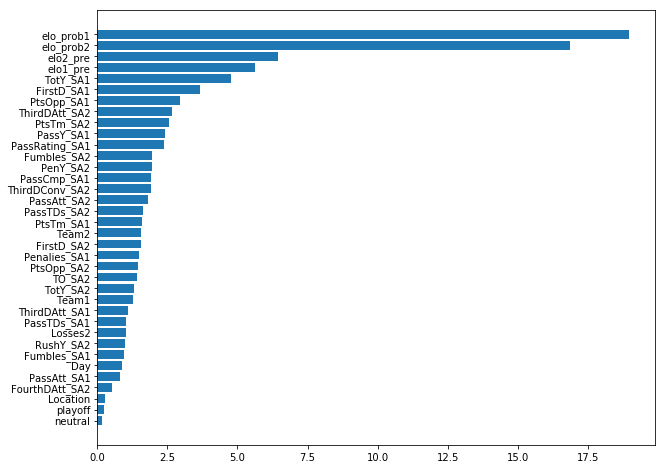

In [267]:
plt.figure(figsize=(10,8))
plt.barh(y=range(len(cb_feats)), width=list(zip(*cb_feats))[1], tick_label = list(zip(*cb_feats))[0])

In [210]:
mod_cols = elas_cols + cat_cols
cb_df = drop_df[mod_cols]
cat_idxs = [list(cb_df.columns).index(x) for x in cat_cols]

model = CatBoostRegressor(cat_features=cat_idxs, iterations=300, learning_rate=0.01, verbose=False)
results05 = cross_validate(model, drop_df[mod_cols], drop_df[target], cv=5, scoring=scoring, return_estimator=True)

0:	learn: 15.1663602	total: 12.1ms	remaining: 3.62s
1:	learn: 15.1458323	total: 57.6ms	remaining: 8.58s
2:	learn: 15.1238806	total: 79ms	remaining: 7.82s
3:	learn: 15.1026602	total: 109ms	remaining: 8.06s
4:	learn: 15.0858816	total: 113ms	remaining: 6.69s
5:	learn: 15.0608048	total: 128ms	remaining: 6.25s
6:	learn: 15.0376003	total: 156ms	remaining: 6.52s
7:	learn: 15.0156097	total: 170ms	remaining: 6.22s
8:	learn: 14.9931841	total: 184ms	remaining: 5.96s
9:	learn: 14.9713875	total: 212ms	remaining: 6.16s
10:	learn: 14.9539810	total: 226ms	remaining: 5.95s
11:	learn: 14.9352076	total: 247ms	remaining: 5.92s
12:	learn: 14.9151010	total: 271ms	remaining: 5.99s
13:	learn: 14.8948034	total: 295ms	remaining: 6.04s
14:	learn: 14.8741396	total: 312ms	remaining: 5.93s
15:	learn: 14.8584358	total: 325ms	remaining: 5.77s
16:	learn: 14.8393436	total: 346ms	remaining: 5.77s
17:	learn: 14.8216230	total: 355ms	remaining: 5.56s
18:	learn: 14.8024158	total: 383ms	remaining: 5.66s
19:	learn: 14.7854347

165:	learn: 13.6330421	total: 3.71s	remaining: 3s
166:	learn: 13.6289536	total: 3.74s	remaining: 2.98s
167:	learn: 13.6246297	total: 3.77s	remaining: 2.96s
168:	learn: 13.6216411	total: 3.79s	remaining: 2.93s
169:	learn: 13.6190052	total: 3.8s	remaining: 2.91s
170:	learn: 13.6155391	total: 3.82s	remaining: 2.88s
171:	learn: 13.6110016	total: 3.84s	remaining: 2.86s
172:	learn: 13.6081197	total: 3.86s	remaining: 2.83s
173:	learn: 13.6051769	total: 3.88s	remaining: 2.81s
174:	learn: 13.6023532	total: 3.89s	remaining: 2.78s
175:	learn: 13.5972129	total: 3.92s	remaining: 2.76s
176:	learn: 13.5945263	total: 3.94s	remaining: 2.74s
177:	learn: 13.5930085	total: 3.94s	remaining: 2.7s
178:	learn: 13.5885108	total: 3.98s	remaining: 2.69s
179:	learn: 13.5848685	total: 4s	remaining: 2.66s
180:	learn: 13.5810671	total: 4.01s	remaining: 2.64s
181:	learn: 13.5786915	total: 4.02s	remaining: 2.61s
182:	learn: 13.5724523	total: 4.04s	remaining: 2.59s
183:	learn: 13.5684450	total: 4.06s	remaining: 2.56s
1

27:	learn: 14.6423854	total: 574ms	remaining: 5.57s
28:	learn: 14.6258820	total: 611ms	remaining: 5.71s
29:	learn: 14.6097401	total: 624ms	remaining: 5.61s
30:	learn: 14.5976449	total: 628ms	remaining: 5.45s
31:	learn: 14.5813182	total: 656ms	remaining: 5.49s
32:	learn: 14.5675870	total: 671ms	remaining: 5.43s
33:	learn: 14.5519912	total: 686ms	remaining: 5.37s
34:	learn: 14.5384752	total: 716ms	remaining: 5.42s
35:	learn: 14.5257078	total: 730ms	remaining: 5.36s
36:	learn: 14.5164772	total: 745ms	remaining: 5.3s
37:	learn: 14.5024027	total: 778ms	remaining: 5.36s
38:	learn: 14.4892993	total: 800ms	remaining: 5.35s
39:	learn: 14.4736823	total: 823ms	remaining: 5.35s
40:	learn: 14.4595620	total: 878ms	remaining: 5.55s
41:	learn: 14.4465250	total: 904ms	remaining: 5.55s
42:	learn: 14.4328433	total: 943ms	remaining: 5.64s
43:	learn: 14.4193628	total: 989ms	remaining: 5.75s
44:	learn: 14.4096626	total: 995ms	remaining: 5.63s
45:	learn: 14.3983769	total: 1.01s	remaining: 5.59s
46:	learn: 14

185:	learn: 13.5379914	total: 4.66s	remaining: 2.85s
186:	learn: 13.5354330	total: 4.68s	remaining: 2.83s
187:	learn: 13.5333075	total: 4.72s	remaining: 2.81s
188:	learn: 13.5286108	total: 4.74s	remaining: 2.78s
189:	learn: 13.5274336	total: 4.75s	remaining: 2.75s
190:	learn: 13.5233254	total: 4.77s	remaining: 2.72s
191:	learn: 13.5199187	total: 4.79s	remaining: 2.69s
192:	learn: 13.5187123	total: 4.82s	remaining: 2.67s
193:	learn: 13.5137492	total: 4.84s	remaining: 2.64s
194:	learn: 13.5107764	total: 4.86s	remaining: 2.61s
195:	learn: 13.5093220	total: 4.87s	remaining: 2.58s
196:	learn: 13.5062155	total: 4.9s	remaining: 2.56s
197:	learn: 13.5017596	total: 4.92s	remaining: 2.53s
198:	learn: 13.4972253	total: 4.95s	remaining: 2.51s
199:	learn: 13.4942144	total: 4.96s	remaining: 2.48s
200:	learn: 13.4922179	total: 4.97s	remaining: 2.45s
201:	learn: 13.4902280	total: 4.98s	remaining: 2.42s
202:	learn: 13.4867512	total: 5s	remaining: 2.39s
203:	learn: 13.4863009	total: 5s	remaining: 2.35s


41:	learn: 14.2956694	total: 896ms	remaining: 5.5s
42:	learn: 14.2837093	total: 918ms	remaining: 5.49s
43:	learn: 14.2701734	total: 968ms	remaining: 5.63s
44:	learn: 14.2591768	total: 990ms	remaining: 5.61s
45:	learn: 14.2477759	total: 999ms	remaining: 5.51s
46:	learn: 14.2351267	total: 1.02s	remaining: 5.51s
47:	learn: 14.2237405	total: 1.04s	remaining: 5.45s
48:	learn: 14.2134685	total: 1.06s	remaining: 5.42s
49:	learn: 14.2007145	total: 1.09s	remaining: 5.46s
50:	learn: 14.1870793	total: 1.12s	remaining: 5.48s
51:	learn: 14.1763373	total: 1.15s	remaining: 5.5s
52:	learn: 14.1655768	total: 1.18s	remaining: 5.48s
53:	learn: 14.1550156	total: 1.2s	remaining: 5.48s
54:	learn: 14.1467721	total: 1.21s	remaining: 5.39s
55:	learn: 14.1349130	total: 1.25s	remaining: 5.43s
56:	learn: 14.1259932	total: 1.25s	remaining: 5.34s
57:	learn: 14.1148946	total: 1.27s	remaining: 5.29s
58:	learn: 14.1032814	total: 1.3s	remaining: 5.3s
59:	learn: 14.0938717	total: 1.32s	remaining: 5.26s
60:	learn: 14.083

206:	learn: 13.3585805	total: 4.34s	remaining: 1.95s
207:	learn: 13.3563440	total: 4.36s	remaining: 1.93s
208:	learn: 13.3531317	total: 4.4s	remaining: 1.91s
209:	learn: 13.3506111	total: 4.41s	remaining: 1.89s
210:	learn: 13.3470616	total: 4.43s	remaining: 1.87s
211:	learn: 13.3460713	total: 4.44s	remaining: 1.84s
212:	learn: 13.3423736	total: 4.47s	remaining: 1.83s
213:	learn: 13.3388865	total: 4.49s	remaining: 1.8s
214:	learn: 13.3366979	total: 4.5s	remaining: 1.78s
215:	learn: 13.3312086	total: 4.53s	remaining: 1.76s
216:	learn: 13.3290918	total: 4.53s	remaining: 1.73s
217:	learn: 13.3274114	total: 4.57s	remaining: 1.72s
218:	learn: 13.3256730	total: 4.58s	remaining: 1.7s
219:	learn: 13.3239728	total: 4.6s	remaining: 1.67s
220:	learn: 13.3216826	total: 4.63s	remaining: 1.66s
221:	learn: 13.3188161	total: 4.65s	remaining: 1.64s
222:	learn: 13.3170189	total: 4.68s	remaining: 1.61s
223:	learn: 13.3128048	total: 4.72s	remaining: 1.6s
224:	learn: 13.3097545	total: 4.73s	remaining: 1.58s

66:	learn: 14.1560885	total: 1.81s	remaining: 6.29s
67:	learn: 14.1466326	total: 1.83s	remaining: 6.26s
68:	learn: 14.1388356	total: 1.85s	remaining: 6.2s
69:	learn: 14.1299932	total: 1.88s	remaining: 6.17s
70:	learn: 14.1215500	total: 1.89s	remaining: 6.08s
71:	learn: 14.1139992	total: 1.89s	remaining: 5.99s
72:	learn: 14.1096555	total: 1.9s	remaining: 5.92s
73:	learn: 14.1015646	total: 1.94s	remaining: 5.91s
74:	learn: 14.0924417	total: 1.96s	remaining: 5.88s
75:	learn: 14.0846439	total: 2.01s	remaining: 5.92s
76:	learn: 14.0759050	total: 2.04s	remaining: 5.9s
77:	learn: 14.0648293	total: 2.08s	remaining: 5.93s
78:	learn: 14.0556310	total: 2.11s	remaining: 5.89s
79:	learn: 14.0510901	total: 2.12s	remaining: 5.82s
80:	learn: 14.0438093	total: 2.13s	remaining: 5.76s
81:	learn: 14.0403787	total: 2.13s	remaining: 5.68s
82:	learn: 14.0339592	total: 2.14s	remaining: 5.61s
83:	learn: 14.0263867	total: 2.17s	remaining: 5.58s
84:	learn: 14.0169202	total: 2.2s	remaining: 5.57s
85:	learn: 14.00

226:	learn: 13.4725828	total: 5.05s	remaining: 1.62s
227:	learn: 13.4704064	total: 5.06s	remaining: 1.6s
228:	learn: 13.4674414	total: 5.09s	remaining: 1.58s
229:	learn: 13.4648010	total: 5.1s	remaining: 1.55s
230:	learn: 13.4629176	total: 5.13s	remaining: 1.53s
231:	learn: 13.4603197	total: 5.15s	remaining: 1.51s
232:	learn: 13.4586743	total: 5.17s	remaining: 1.49s
233:	learn: 13.4576081	total: 5.18s	remaining: 1.46s
234:	learn: 13.4556798	total: 5.21s	remaining: 1.44s
235:	learn: 13.4527082	total: 5.23s	remaining: 1.42s
236:	learn: 13.4508468	total: 5.26s	remaining: 1.4s
237:	learn: 13.4469818	total: 5.28s	remaining: 1.37s
238:	learn: 13.4439431	total: 5.29s	remaining: 1.35s
239:	learn: 13.4408885	total: 5.32s	remaining: 1.33s
240:	learn: 13.4389120	total: 5.33s	remaining: 1.3s
241:	learn: 13.4357516	total: 5.35s	remaining: 1.28s
242:	learn: 13.4314336	total: 5.38s	remaining: 1.26s
243:	learn: 13.4281456	total: 5.39s	remaining: 1.24s
244:	learn: 13.4270670	total: 5.41s	remaining: 1.2

84:	learn: 13.9277740	total: 1.54s	remaining: 3.9s
85:	learn: 13.9188358	total: 1.56s	remaining: 3.88s
86:	learn: 13.9119215	total: 1.57s	remaining: 3.84s
87:	learn: 13.9057732	total: 1.58s	remaining: 3.81s
88:	learn: 13.8973882	total: 1.6s	remaining: 3.8s
89:	learn: 13.8920345	total: 1.63s	remaining: 3.8s
90:	learn: 13.8884177	total: 1.63s	remaining: 3.75s
91:	learn: 13.8837620	total: 1.64s	remaining: 3.7s
92:	learn: 13.8771551	total: 1.65s	remaining: 3.67s
93:	learn: 13.8705514	total: 1.68s	remaining: 3.68s
94:	learn: 13.8622339	total: 1.69s	remaining: 3.65s
95:	learn: 13.8572230	total: 1.71s	remaining: 3.63s
96:	learn: 13.8513750	total: 1.74s	remaining: 3.63s
97:	learn: 13.8449281	total: 1.75s	remaining: 3.61s
98:	learn: 13.8417931	total: 1.75s	remaining: 3.56s
99:	learn: 13.8349420	total: 1.79s	remaining: 3.57s
100:	learn: 13.8256989	total: 1.8s	remaining: 3.55s
101:	learn: 13.8189672	total: 1.82s	remaining: 3.53s
102:	learn: 13.8140371	total: 1.84s	remaining: 3.53s
103:	learn: 13.

249:	learn: 13.3217053	total: 4.28s	remaining: 855ms
250:	learn: 13.3196556	total: 4.31s	remaining: 841ms
251:	learn: 13.3157320	total: 4.33s	remaining: 824ms
252:	learn: 13.3127216	total: 4.34s	remaining: 807ms
253:	learn: 13.3106534	total: 4.38s	remaining: 794ms
254:	learn: 13.3089821	total: 4.4s	remaining: 777ms
255:	learn: 13.3065048	total: 4.42s	remaining: 760ms
256:	learn: 13.3055545	total: 4.44s	remaining: 743ms
257:	learn: 13.3003884	total: 4.47s	remaining: 728ms
258:	learn: 13.2993105	total: 4.49s	remaining: 711ms
259:	learn: 13.2987019	total: 4.5s	remaining: 692ms
260:	learn: 13.2962423	total: 4.53s	remaining: 676ms
261:	learn: 13.2934671	total: 4.54s	remaining: 659ms
262:	learn: 13.2904340	total: 4.57s	remaining: 643ms
263:	learn: 13.2895290	total: 4.58s	remaining: 624ms
264:	learn: 13.2874697	total: 4.59s	remaining: 607ms
265:	learn: 13.2857728	total: 4.61s	remaining: 589ms
266:	learn: 13.2853249	total: 4.62s	remaining: 571ms
267:	learn: 13.2820909	total: 4.64s	remaining: 5

In [212]:
cb_elascols = [np.mean(results05['test_R2']), -np.mean(results05['test_MSE'])]

In [213]:
cb_elascols

[0.14027666775304895, 189.16926498648328]

In [211]:
results05

{'fit_time': array([6.33536196, 7.51810908, 6.44126415, 6.50070405, 5.3787601 ]),
 'score_time': array([0.01608706, 0.00649118, 0.008461  , 0.00655484, 0.0075469 ]),
 'estimator': (<catboost.core.CatBoostRegressor at 0x1c2e796e80>,
  <catboost.core.CatBoostRegressor at 0x1c291c4d30>),
 'test_R2': array([0.14271583, 0.13429191, 0.11383809, 0.16306994, 0.14746756]),
 'train_R2': array([0.19925159, 0.2043706 , 0.20689693, 0.19398908, 0.19327517]),
 'test_MSE': array([-181.43947109, -184.45475209, -200.27539427, -183.35463133,
        -196.32207615]),
 'train_MSE': array([-178.02612344, -176.57674725, -173.51167047, -177.72555002,
        -175.47758504])}

In [224]:
results05['estimator']

In [226]:
model.feature_names_

CatboostError: Model is not fitted.

### Results summary

In [ ]:
res_df = pd.DataFrame([ols_lassocols, ols_elascols, cb_elascols], columns=['test R2', 'test MSE'], 
                      index=['OLS - L1 cols', 'OLS - EN cols', 'CatBoost - EN cols'])

In [217]:
res_df

test R2    test MSE
OLS - L1 cols       0.142333  188.691964
OLS - EN cols       0.142665  188.630304
CatBoost - EN cols  0.140277  189.169265